### Manipulator Inverse Kinematics (IK)

In [1]:
import time
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_parser import MuJoCoManipulatorParserClass
from util import rpy2r,r2w,trim_scale,get_colors
print ("Done.")

Done.


### Parse manipulator

Creating offscreen glfw


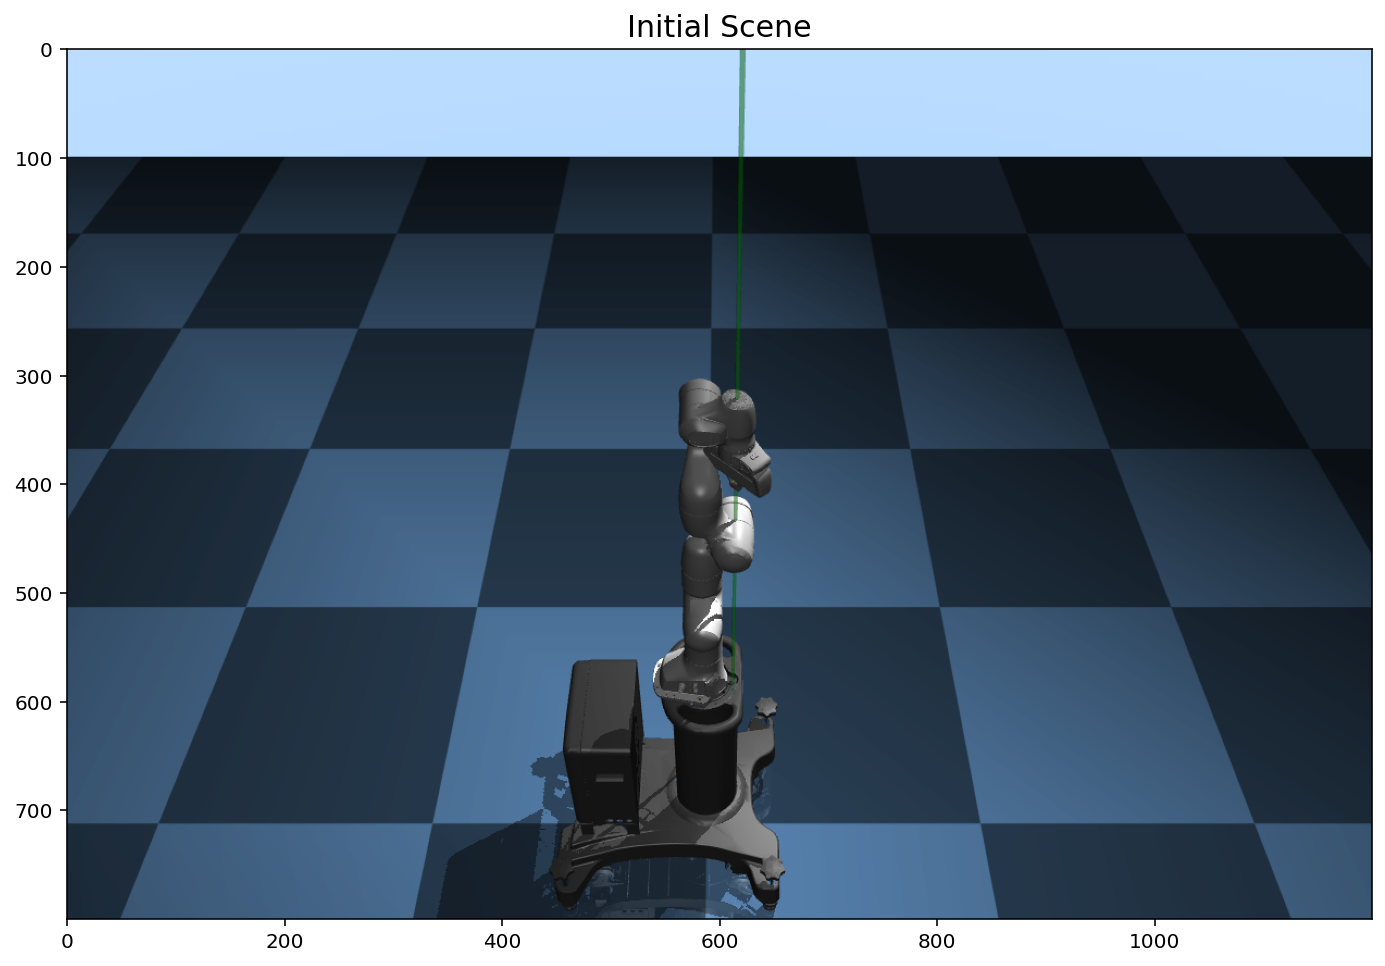

In [2]:
env = MuJoCoManipulatorParserClass(
    name='Panda',rel_path='../asset/panda/franka_panda.xml',ee_name='panda_eef',VERBOSE=False)
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,title_str='Initial Scene',title_fs=15)

### Loop (Kinematic only)

In [8]:
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_tick(max_tick=200)
env.reset() # reset env

q      = env.get_q_rev()
p_EE   = env.get_p_body(body_name='panda_eef')
R_EE   = env.get_R_body(body_name='panda_eef')
p_trgt = p_EE + np.array([0.5,0.0,-0.5])
R_trgt = R_EE

err_list = np.zeros(env.max_tick)
q_list   = np.zeros((env.max_tick,env.n_rev_joint))
while env.IS_ALIVE():
    # Solve IK
    dq,err = env.one_step_ik(body_name='panda_eef',p_trgt=p_trgt,R_trgt=R_trgt,th=1.0*np.pi/180.0)
    q = q + dq
    
    # FK and render
    env.add_marker(pos=p_EE,radius=0.03,color=np.array([0,1,0,0.5]),label='EE tick:[%d]'%(env.tick))
    env.add_marker(pos=p_trgt,radius=0.03,color=np.array([1,0,0,0.5]),label='Target')
    env.forward_and_render(q_rev=q,RENDER_ALWAYS=True)
    env.print(print_every_sec=1.0,VERBOSE=1)
    
    # Append
    err_list[env.tick-1] = np.linalg.norm(err)
    q_list[env.tick-1,:] = q

print ("Done.")

Creating window glfw
tick:[1/201], sec_wall:[0.092]sec, sec_sim:[0.002]sec
Done.


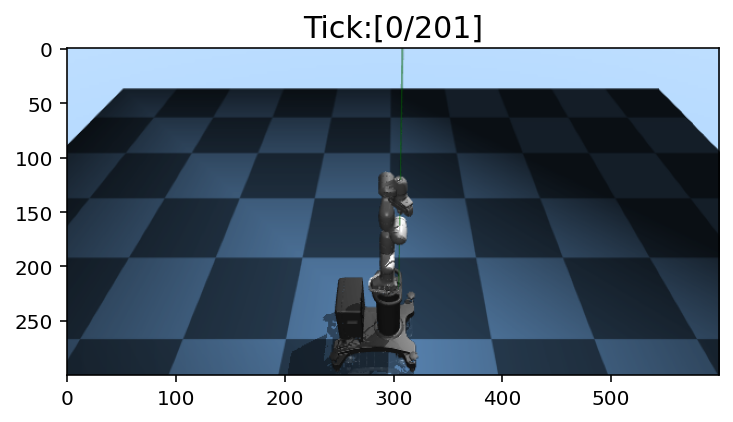

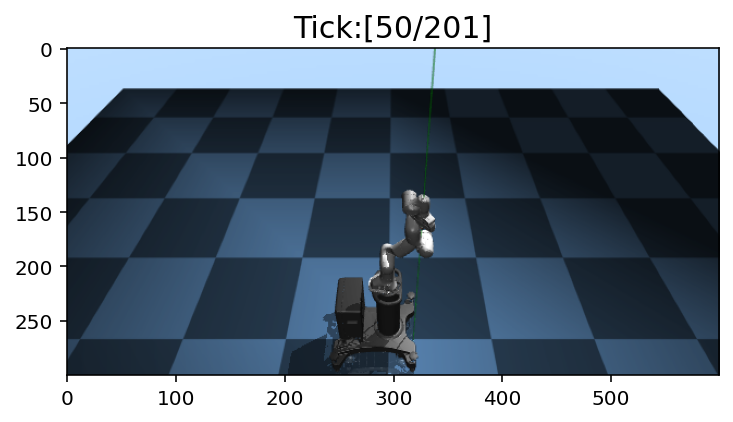

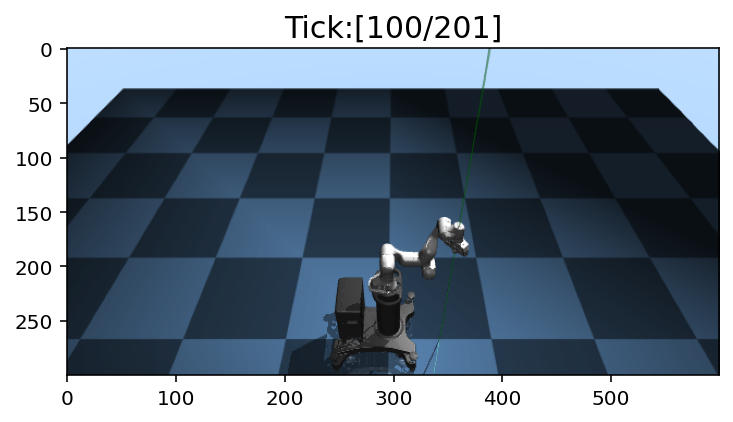

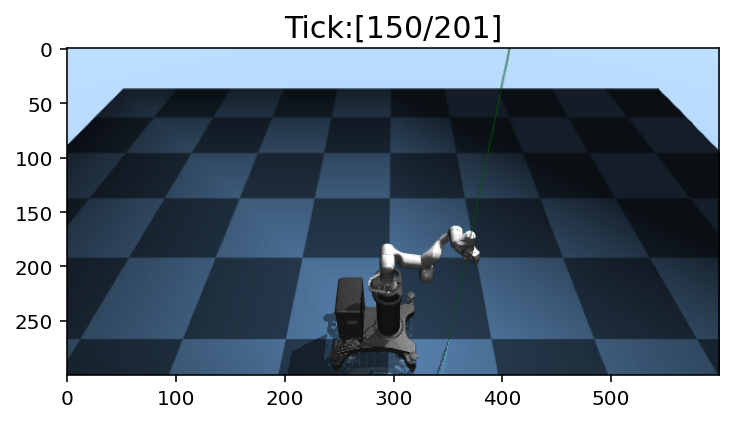

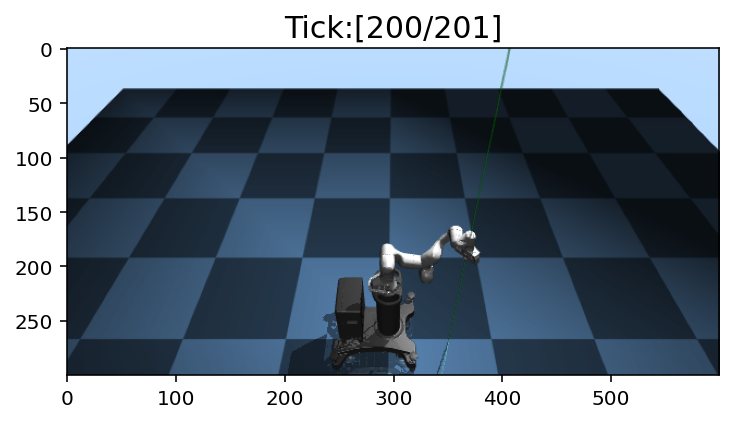

In [9]:
for tick in np.linspace(0,env.max_tick-1,5).astype(np.int32):
    env.forward(q_rev=q_list[tick,:])
    env.plot_scene(figsize=(6,3),render_w=600,render_h=300,
                   title_str='Tick:[%d/%d]'%(tick,env.max_tick),title_fs=15)

In [10]:
env.terminate_viewer() # terminate viewer

### Plot joint trajectories and IK error

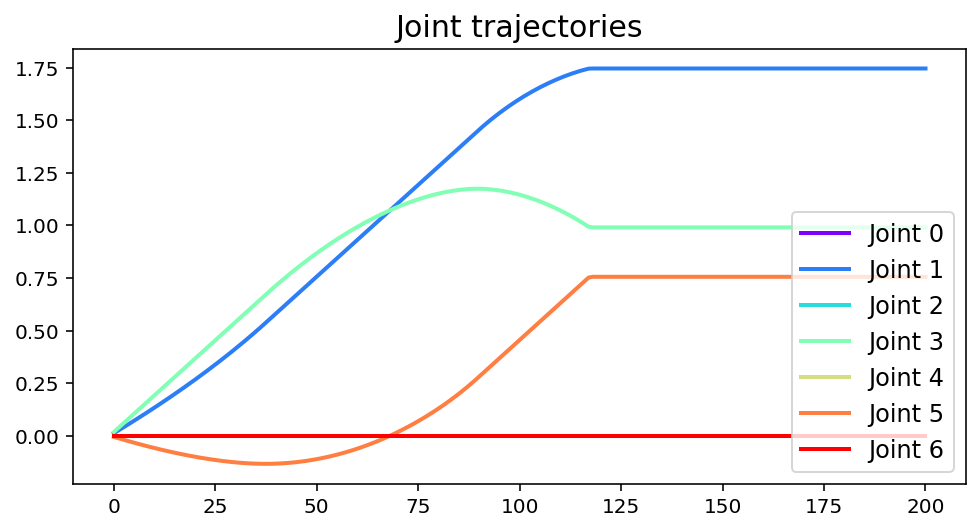

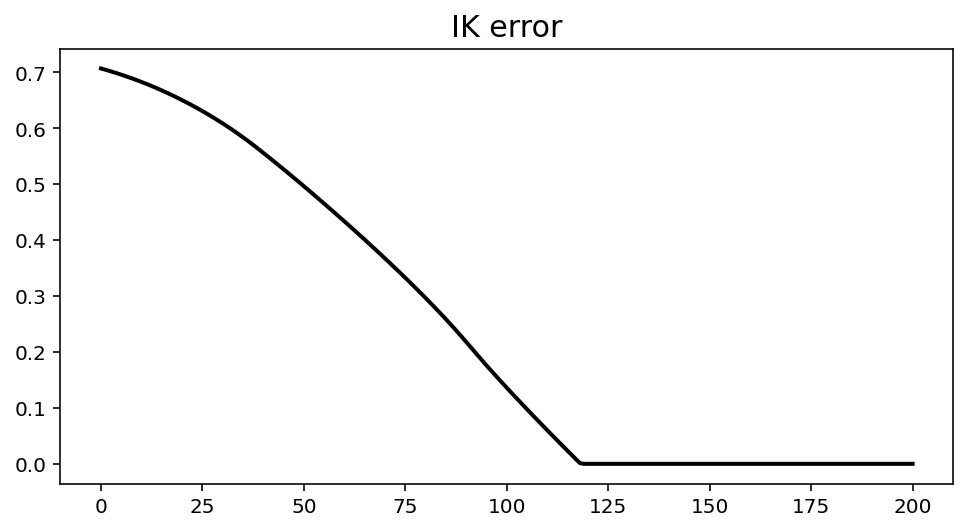

In [12]:
# Plot joint trajectories
plt.figure(figsize=(8,4))
colors = get_colors(n=env.n_rev_joint,cm=plt.cm.rainbow)
for i_idx in range(env.n_rev_joint):
    color = colors[i_idx]
    plt.plot(q_list[:,i_idx],'-',lw=2,color=color,label='Joint %d'%(i_idx))
plt.legend(fontsize=12,loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()

# Plot IK error
plt.figure(figsize=(8,4))
plt.plot(err_list,'-',lw=2,color='k')
plt.title('IK error',fontsize=15)
plt.show()